# **Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [62]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import shutil
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import load_img

In [63]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [64]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Test")

In [65]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [66]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [67]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [68]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [69]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

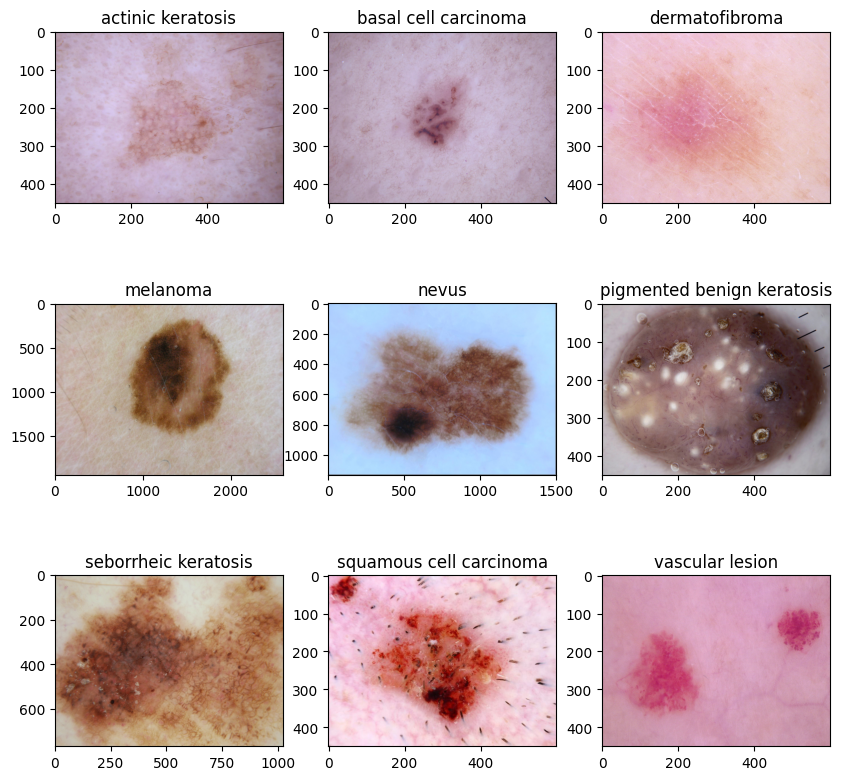

In [70]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [72]:
num_classes = 9
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [73]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Train the model

In [75]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 27s 196ms/step - loss: 2.0678 - accuracy: 0.1875 - val_loss: 2.0369 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0434 - accuracy: 0.1819 - val_loss: 1.9929 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 112ms/step - loss: 1.9771 - accuracy: 0.2427 - val_loss: 1.9572 - val_accuracy: 0.2998
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 1.9196 - accuracy: 0.2634 - val_loss: 1.8047 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 6s 112ms/step - loss: 1.7739 - accuracy: 0.3064 - val_loss: 1.6632 - val_accuracy: 0.3669
Epoch 6/20
56/56 [==============================] - 6s 111ms/step - loss: 1.7601 - accuracy: 0.3287 - val_loss: 1.6150 - val_accuracy: 0.3960
Epoch 7/20
56/56 [==============================] - 6s 112ms/step - loss: 1.6586 - accuracy: 0.3711 - val_loss: 1.6087 - val_accuracy: 0.3960
Epoch 8/20
56/56

### Visualizing training results

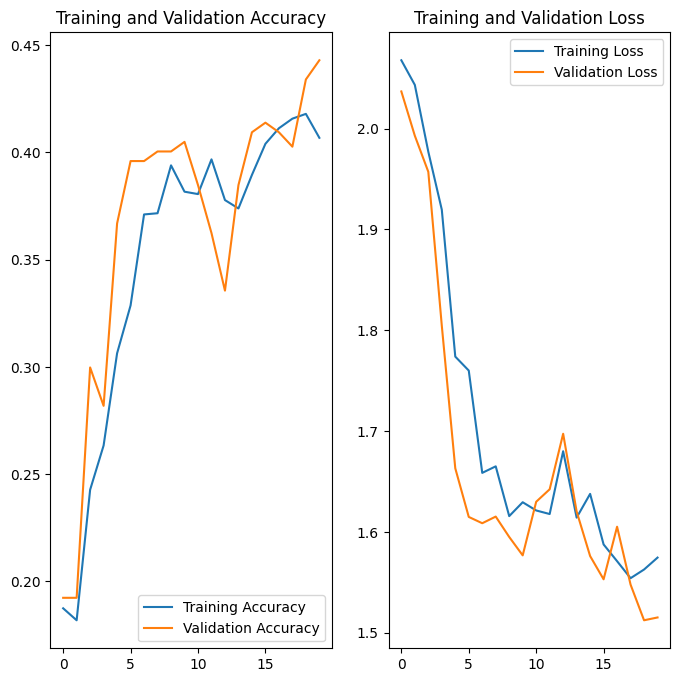

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [77]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 21ms/step - loss: 1.5153 - accuracy: 0.4430
Train Accuracy:  0.4575892984867096
Validation Accuracy:  0.4429530203342438
Train Loss:  1.4892412424087524
Validation Loss 1.5152559280395508


# Observations

1. The accuracy of the model for the Training data set is at 45.8%. and the Validation accuracy is 44.3% which shows no clear sign of overfiting

2. The model seems to be underfitted because we can see the accuracy is very low and the loss function is high for both train & validation set.

3. Need to take action inorder to improve the accuracy score.

### visualize how your augmentation strategy works for one instance of training image.

### Todo:
### Create the model, compile and train the model


In [79]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

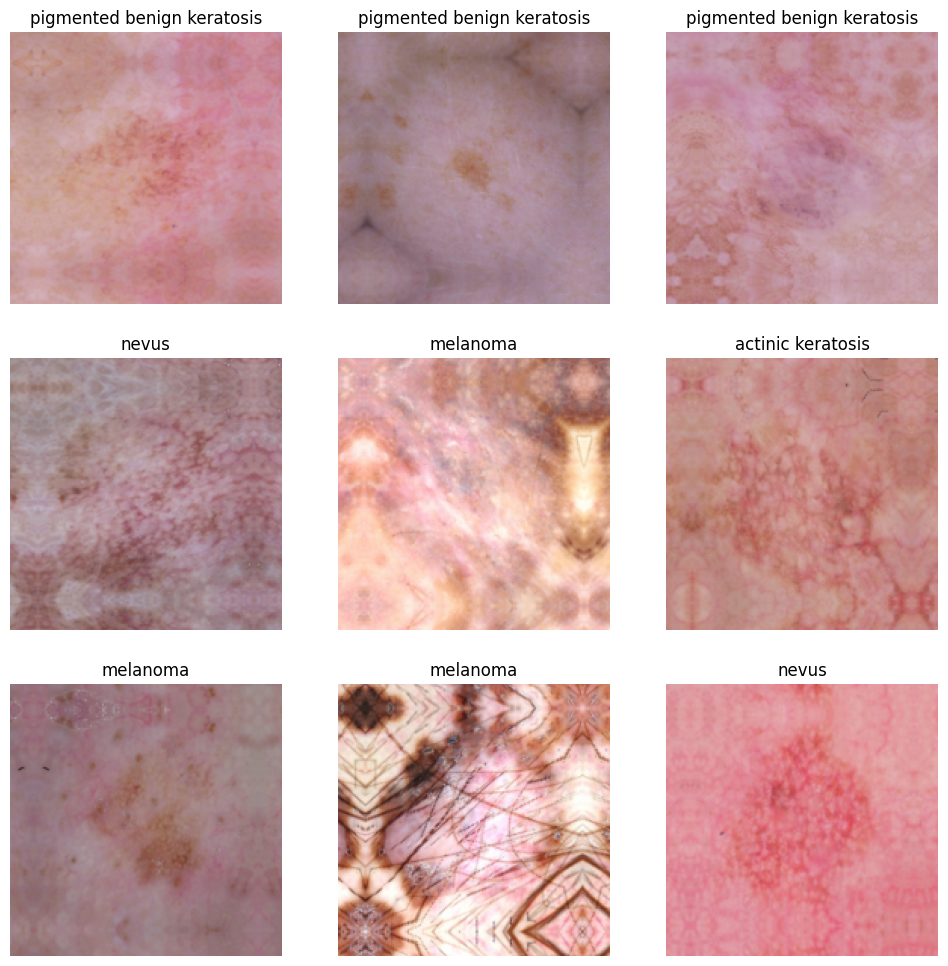

In [80]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [81]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [82]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [83]:
## Your code goes here
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 8s 109ms/step - loss: 2.0554 - accuracy: 0.1931 - val_loss: 2.0147 - val_accuracy: 0.2103
Epoch 2/30
56/56 [==============================] - 6s 103ms/step - loss: 2.0556 - accuracy: 0.2148 - val_loss: 2.0559 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 6s 104ms/step - loss: 2.3583 - accuracy: 0.2042 - val_loss: 2.1133 - val_accuracy: 0.1588
Epoch 4/30
56/56 [==============================] - 6s 101ms/step - loss: 2.0539 - accuracy: 0.1875 - val_loss: 2.0238 - val_accuracy: 0.2058
Epoch 5/30
56/56 [==============================] - 6s 104ms/step - loss: 2.0331 - accuracy: 0.1942 - val_loss: 2.0310 - val_accuracy: 0.1924
Epoch 6/30
56/56 [==============================] - 6s 102ms/step - loss: 2.0247 - accuracy: 0.2026 - val_loss: 2.0206 - val_accuracy: 0.2081
Epoch 7/30
56/56 [==============================] - 6s 103ms/step - loss: 2.0255 - accuracy: 0.1981 - val_loss: 2.0205 - val_accuracy: 0.2237
Epoch 

### Visualizing the results

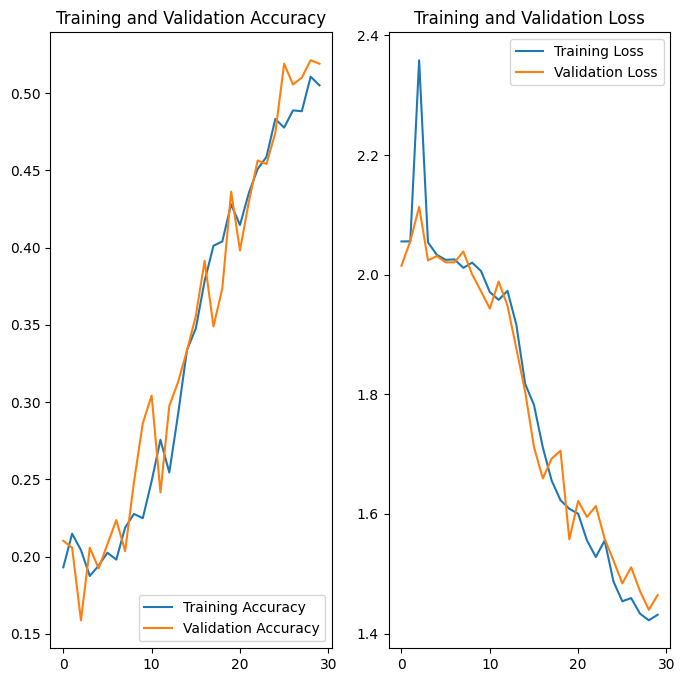

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 22ms/step - loss: 1.4644 - accuracy: 0.5190
Train Accuracy:  0.4866071343421936
Validation Accuracy:  0.5190156698226929
Train Loss:  1.4435282945632935
Validation Loss 1.4643558263778687


**Finding from Second Model**

1. There is an improvement in the accuracy and no sign of overfitting but still we need to improve it
2. We can increase the epochs cycle to improve the accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [86]:
# Classes present in the sample
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [87]:
# Defining empty list to store the path & labels
path_list=[]
label_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
1,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
2,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
3,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
4,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion
2235,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion
2236,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion
2237,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion


In [88]:
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
1,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
2,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
3,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
4,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion
2235,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion
2236,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion
2237,/content/gdrive/MyDrive/Deep Learning/Train/va...,vascular lesion


<BarContainer object of 9 artists>

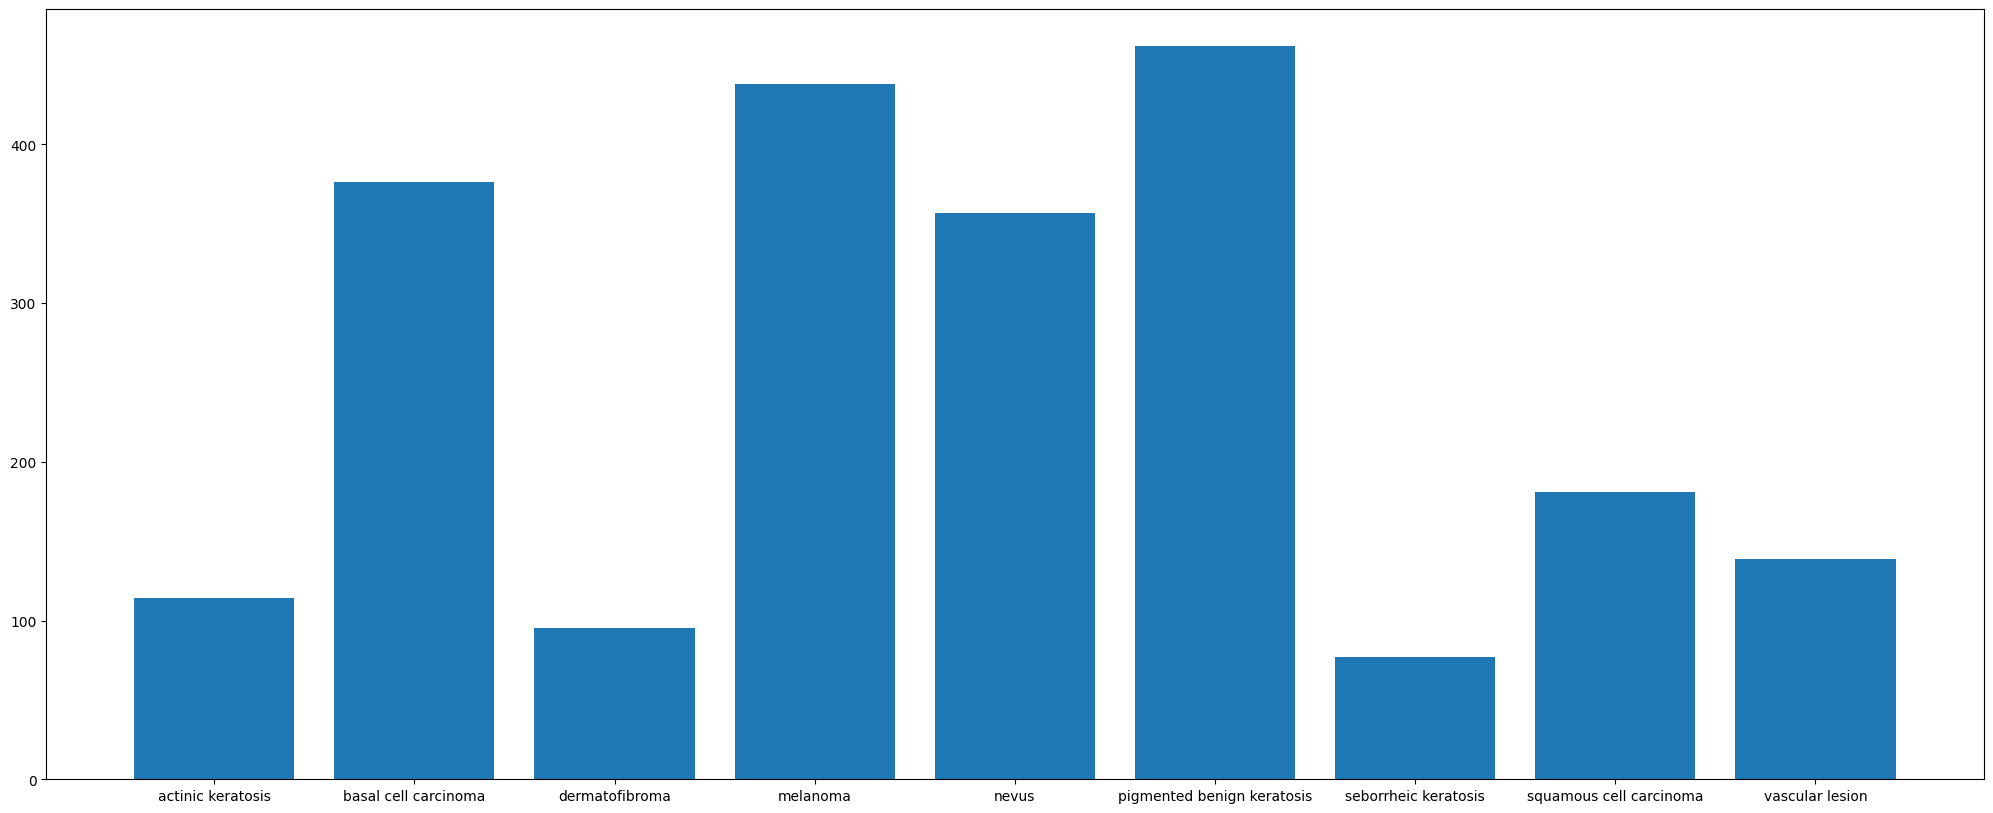

In [89]:
# plotting bar graph for visualization
label_count=[]
for i in class_names:
    label_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(20,10))
plt.bar(class_names,label_count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
####   **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
####  **pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [90]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [91]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7D7326A3DE10>: 100%|██████████| 500/500 [00:50<00:00,  9.86 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D73A84CD7E0>: 100%|██████████| 500/500 [00:37<00:00, 13.42 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D7390186170>: 100%|██████████| 500/500 [00:39<00:00, 12.58 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D734B929030>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D739BF7BA90>: 100%|██████████| 500/500 [00:43<00:00, 11.44 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D73906BE4A0>: 100%|██████████| 500/500 [00:44<00:00, 11.13 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D73906BD8D0>: 100%|██████████| 500/500 [00:39<00:00, 12.57 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D73A84298A0>: 100%|██████████| 500/500 [00:43<00:00, 11.58 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7D73AAF29F30>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [92]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [93]:
for i in class_names:
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)
dataframe_dict_original = dict(zip(path_list, label_list))
image_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
image_df

,Path,Label
0,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
1,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
2,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
3,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
4,/content/gdrive/MyDrive/Deep Learning/Train/ac...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/Deep Learning/Train/ou...,vascular lesion
6735,/content/gdrive/MyDrive/Deep Learning/Train/ou...,vascular lesion
6736,/content/gdrive/MyDrive/Deep Learning/Train/ou...,vascular lesion
6737,/content/gdrive/MyDrive/Deep Learning/Train/ou...,vascular lesion


In [34]:
image_df['Label'].value_counts()

Label
melanoma                      1353
pigmented benign keratosis    1342
basal cell carcinoma          1150
nevus                         1065
squamous cell carcinoma        547
vascular lesion                429
actinic keratosis              330
dermatofibroma                 300
seborrheic keratosis           223
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [97]:
# Define the paths
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Train/output")
data_dir_train2 = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Train")

# Count the number of jpg files in each directory
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
image_count_train2 = len(list(data_dir_train2.glob('*/*.jpg')))

# Combine the counts
total_image_count = image_count_train1 + image_count_train2

# Print the combined count
print(total_image_count)


6739


In [100]:
# Combining both directory images for final model building
# Define the source paths
source_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Train/output")
source_dir_train2 = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/Train")

# Define the destination path for the combined dataset
destination_dir = pathlib.Path("/content/gdrive/MyDrive/Deep Learning/CombinedTrain2")

# Create the destination directory if it doesn't exist
destination_dir.mkdir(parents=True, exist_ok=True)

# Function to copy files from source to destination
def copy_files(src_dir, dest_dir):
    for image_path in src_dir.glob('*/*.jpg'):
        # Create the same subdirectory structure in the destination
        relative_path = image_path.relative_to(src_dir)
        destination_path = dest_dir / relative_path
        destination_path.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy(image_path, destination_path)

# Copy files from both source directories to the destination
copy_files(source_dir_train1, destination_dir)
copy_files(source_dir_train2, destination_dir)

print(f"Files from {source_dir_train1} and {source_dir_train2} have been copied to {destination_dir}.")

# Define image parameters
img_height = 180  # height
img_width = 180   # width
batch_size = 32   # batch size

# Create the dataset from the combined directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  destination_dir,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Files from /content/gdrive/MyDrive/Deep Learning/Train/output and /content/gdrive/MyDrive/Deep Learning/Train have been copied to /content/gdrive/MyDrive/Deep Learning/CombinedTrain2.
Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [101]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  destination_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [102]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [103]:
# Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [105]:
# Your code goes here, using 30 epochs due to limitation on hardware
epochs =30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 48s 277ms/step - loss: 1.3072 - accuracy: 0.5352 - val_loss: 1.2846 - val_accuracy: 0.5494
Epoch 2/30
169/169 [==============================] - 48s 269ms/step - loss: 1.2087 - accuracy: 0.5747 - val_loss: 1.3083 - val_accuracy: 0.5264
Epoch 3/30
169/169 [==============================] - 46s 264ms/step - loss: 1.0764 - accuracy: 0.6191 - val_loss: 1.1254 - val_accuracy: 0.5991
Epoch 4/30
169/169 [==============================] - 47s 272ms/step - loss: 0.9947 - accuracy: 0.6460 - val_loss: 1.1702 - val_accuracy: 0.5984
Epoch 5/30
169/169 [==============================] - 48s 279ms/step - loss: 0.8756 - accuracy: 0.6905 - val_loss: 1.0127 - val_accuracy: 0.6615
Epoch 6/30
169/169 [==============================] - 46s 265ms/step - loss: 0.7891 - accuracy: 0.7122 - val_loss: 1.0361 - val_accuracy: 0.6526
Epoch 7/30
169/169 [==============================] - 46s 265ms/step - loss: 0.6757 - accuracy: 0.7570 - val_loss: 0.9251 - val_ac

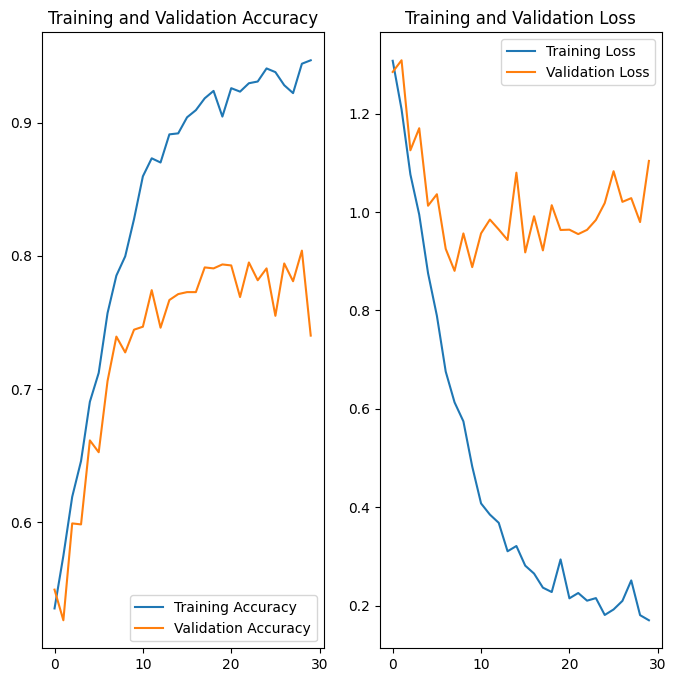

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 9s 147ms/step - loss: 1.1038 - accuracy: 0.7402
Train Accuracy:  0.8877967596054077
Validation Accuracy:  0.7401633262634277
Train Loss:  0.30702582001686096
Validation Loss 1.103808045387268


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. Accuracy has been improved significantly after treating the class imbalance using augmentation.
2. Train Accuracy 88% and Validation Accuracy 74%, with very less loss in train and validation.
3. Though i have implemented dropout but still i can see some evidence of overfitting.(increasing some more layers of dropout would certainly reduce overfitting & increasing epoch cycle will help improve accuracy further, but couldn't execute it due to **hardware restriction**)